In [1]:
from ultralytics import YOLO
import os
from hierarchical_yolo.mscoco_hierarchical_model import MSCOCOHierarchicalDetectionTrainer
import hierarchical_yolo.mscoco_hierarchical_model
import hierarchical_yolo.yolo_utils
import hierarchical_loss.path_utils
import hierarchical_loss.viz_utils
import ultralytics
import torch

In [2]:
# basic locations of data, etc
DATASETS = ultralytics.settings['datasets_dir']
WEIGHTS = ultralytics.settings['weights_dir']
RUNS = ultralytics.settings['runs_dir']

# configure where base weights are downloaded/stored
YOLO_BASE_WEIGHTS = os.path.join(WEIGHTS, "yolov8n.pt")

# configure project runs save locations
BASE_PROJECT = os.path.join(RUNS, 'coco128')
HIERARCHICAL_PROJECT = os.path.join(RUNS, 'hierarchical_coco128')

# find where data is downloaded/stored
DATA = os.path.join(DATASETS, 'coco128')
IMAGES_PATH = os.path.join(DATA, 'images', 'train2017')

# find model configurations
MODEL_CONFIGS = '../models'
COCO128_MODELS = os.path.join(MODEL_CONFIGS, 'coco128')
YOLO_MODEL_YAML = os.path.join(COCO128_MODELS, 'hierarchicalcoco128yolov8.yaml')
YOLO_DATASET_YAML = os.path.join(COCO128_MODELS, 'hierarchicalcoco128.yaml')

In [3]:
devices = list(range(torch.cuda.device_count()))
devices

[0, 1, 2, 3, 4, 5, 6]

In [4]:
trained_models = os.listdir(HIERARCHICAL_PROJECT)
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))
latest_model

'train7'

In [5]:
trained_model = (
    YOLO(os.path.join(HIERARCHICAL_PROJECT, latest_model, 'weights', 'best.pt')).to('cuda:6')
    #    .to('cuda') # uncomment if you'd like to use the gpu
)
trained_model.eval()

YOLO(
  (model): HierarchicalDetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, tra

In [6]:
MSCOCOHierarchicalDetectionTrainer.id_to_name

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [7]:
test_img = os.path.join(IMAGES_PATH, '000000000257.jpg')
test_img

'/home/noaa_brown/datasets/coco128/images/train2017/000000000257.jpg'

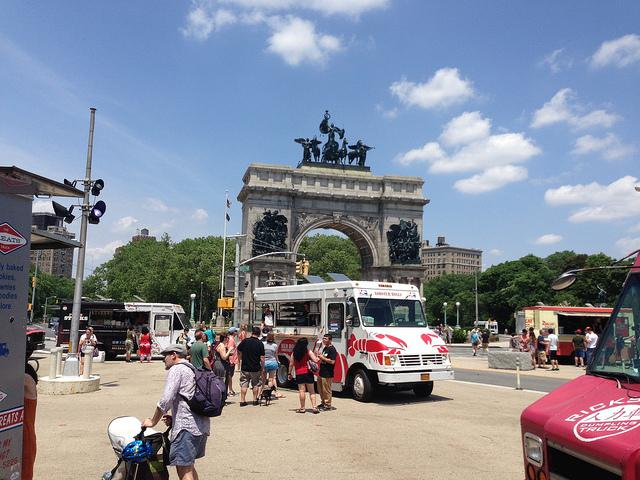

In [8]:
import torch
from PIL import Image

# Load and preprocess
image = Image.open(test_img).convert('RGB')
image

In [9]:
raw_predictions = hierarchical_yolo.yolo_utils.yolo_raw_predict(trained_model, [image], (640, 640))[0]
raw_predictions.shape

torch.Size([113, 8400])

In [10]:
import treelib

In [11]:
def viz_tree(hierarchy, name_map, vals):
    tree = treelib.Tree()
    visited = set()
    for child, parent in hierarchy.items():
        branch = [child, parent]
        while parent in hierarchy and parent not in visited:
            parent = hierarchy[parent]
            branch.append(parent)
        end = len(branch) - 1
        while branch[end] in visited:
            end -= 1
        for j in range(end, -1, -1):
            node = branch[j]
            visited.add(node)
            tree.create_node("{} : {}".format(str(name_map[node]), str(vals[node])), node, parent = hierarchy[node] if node in hierarchy else None)      
    return tree

In [12]:
predicted_boxes, predicted_paths, predicted_path_scores = hierarchical_yolo.yolo_utils.hierarchical_predict(trained_model, MSCOCOHierarchicalDetectionTrainer._hierarchy, [image])

In [13]:
predicted_boxes

[tensor([[511.5649,  53.7365, 136.0283, 236.5742, 234.7191, 519.1658, 118.6621,  77.9250, 188.0226, 137.1769, 287.7194, 306.8399, 173.9554,  89.2625,  26.5493, 261.0897, 276.1763, 469.8873, 533.2870, 192.7926, 583.8590, 261.3950, 289.8799, 523.9415, 305.6419, 292.0836, 220.9546, 133.0880, 224.2521, 570.3358, 208.6927,
          123.2481, 107.9898, 256.2850, 520.0771, 307.1597, 312.0921],
         [407.6038, 401.5618, 457.5740, 362.6651, 436.0366, 339.9094, 564.2133, 435.1991, 433.0546, 435.7963, 450.5418, 446.3356, 483.1938, 267.7589, 437.5326, 406.4103, 447.3450, 434.8889, 437.4554, 431.6479, 433.0223, 442.4166, 449.3353, 437.3588, 452.2949, 164.3423, 441.1300, 430.0576, 436.3876, 437.1996, 442.0995,
          431.5740, 554.8837, 485.0781, 438.5563, 472.0888, 443.4765],
         [621.9309, 189.3438, 210.8428, 452.7892, 265.6056, 639.7416, 168.3499,  98.6262, 211.1591, 154.3173, 316.4644, 336.1448, 227.4251, 106.5618,  46.4640, 274.1569, 294.1907, 481.7808, 548.2586, 206.7813, 596.1932

In [14]:
predicted_boxes[0], predicted_paths[0], predicted_path_scores[0]

(tensor([[511.5649,  53.7365, 136.0283, 236.5742, 234.7191, 519.1658, 118.6621,  77.9250, 188.0226, 137.1769, 287.7194, 306.8399, 173.9554,  89.2625,  26.5493, 261.0897, 276.1763, 469.8873, 533.2870, 192.7926, 583.8590, 261.3950, 289.8799, 523.9415, 305.6419, 292.0836, 220.9546, 133.0880, 224.2521, 570.3358, 208.6927,
          123.2481, 107.9898, 256.2850, 520.0771, 307.1597, 312.0921],
         [407.6038, 401.5618, 457.5740, 362.6651, 436.0366, 339.9094, 564.2133, 435.1991, 433.0546, 435.7963, 450.5418, 446.3356, 483.1938, 267.7589, 437.5326, 406.4103, 447.3450, 434.8889, 437.4554, 431.6479, 433.0223, 442.4166, 449.3353, 437.3588, 452.2949, 164.3423, 441.1300, 430.0576, 436.3876, 437.1996, 442.0995,
          431.5740, 554.8837, 485.0781, 438.5563, 472.0888, 443.4765],
         [621.9309, 189.3438, 210.8428, 452.7892, 265.6056, 639.7416, 168.3499,  98.6262, 211.1591, 154.3173, 316.4644, 336.1448, 227.4251, 106.5618,  46.4640, 274.1569, 294.1907, 481.7808, 548.2586, 206.7813, 596.1932

In [15]:
predicted_boxes[0].shape

torch.Size([4, 37])

In [16]:
tpaths, tscores = hierarchical_loss.path_utils.truncate_paths_marginals(predicted_paths[0], predicted_path_scores[0], threshold=0.2)

In [17]:
fboxes, fpaths, fscores = hierarchical_loss.path_utils.filter_empty_paths(predicted_boxes[0], tpaths, tscores)
fboxes.shape, len(fpaths), len(fscores)

(torch.Size([4, 37]), 37, 37)

In [18]:
ROOT_NODE_IDX = 80

In [19]:
one_full_pred_loc = int(torch.argmin(torch.abs(raw_predictions[4+ROOT_NODE_IDX,:] - float(fscores[0][0]))))
one_full_obj_preds = raw_predictions[4:, one_full_pred_loc]
one_full_obj_preds

tensor([5.7145e-07, 2.3923e-03, 7.0576e-04, 1.6491e-02, 7.1962e-04, 7.2278e-01, 2.1210e-02, 5.0695e-03, 6.0331e-04, 6.3559e-01, 7.8342e-04, 3.5988e-03, 1.5913e-04, 2.1034e-03, 1.8617e-03, 1.4089e-03, 2.1077e-02, 1.4904e-04, 3.6055e-02, 1.4064e-05, 4.0155e-02, 6.9366e-04, 1.2357e-05, 1.3225e-03, 6.4687e-03, 3.9856e-03,
        9.3347e-04, 2.0389e-02, 4.5328e-04, 1.6044e-04, 2.1060e-04, 1.9955e-06, 4.8828e-05, 1.3622e-04, 1.9284e-05, 1.7979e-03, 1.4784e-02, 7.0313e-05, 5.7960e-02, 7.0758e-02, 7.4436e-01, 3.2848e-02, 1.5150e-03, 4.3511e-06, 1.1068e-02, 1.2610e-04, 3.2004e-06, 1.5882e-04, 2.7391e-01, 5.2705e-04, 7.0098e-05, 3.4242e-03,
        4.9707e-04, 5.3305e-05, 3.1594e-04, 7.1151e-03, 1.7469e-04, 1.5927e-04, 1.9784e-03, 6.2165e-04, 6.9438e-04, 1.2207e-01, 3.0325e-04, 1.2724e-03, 1.6955e-05, 2.1338e-05, 2.2919e-04, 8.5698e-07, 3.7347e-03, 7.0058e-02, 4.1787e-04, 1.2489e-04, 7.4926e-04, 3.1797e-05, 1.4497e-04, 2.3762e-04, 3.0588e-03, 7.6424e-06,
        3.4679e-05, 1.1904e-04, 9.9897e-

In [20]:
viz_tree(MSCOCOHierarchicalDetectionTrainer._hierarchy, MSCOCOHierarchicalDetectionTrainer.id_to_name, list(map(lambda x: '{:.4f}'.format(x), one_full_obj_preds))).show()

object : 0.9990
├── accessory_and_item : 0.0153
│   ├── home_and_office_item : 0.0018
│   │   ├── book : 0.0000
│   │   ├── clock : 0.0001
│   │   ├── scissors : 0.0031
│   │   ├── teddy bear : 0.0000
│   │   └── vase : 0.0002
│   └── personal_accessory : 0.0001
│       ├── backpack : 0.0065
│       ├── handbag : 0.0009
│       ├── suitcase : 0.0005
│       ├── tie : 0.0204
│       └── umbrella : 0.0040
├── food : 0.1507
│   ├── dessert : 0.0004
│   │   ├── cake : 0.0071
│   │   └── donut : 0.0003
│   ├── fruit : 0.0000
│   │   ├── apple : 0.0002
│   │   ├── banana : 0.0000
│   │   └── orange : 0.0005
│   ├── prepared_meal : 0.0000
│   │   ├── hot dog : 0.0005
│   │   ├── pizza : 0.0001
│   │   └── sandwich : 0.2739
│   └── vegetable : 0.0002
│       ├── broccoli : 0.0001
│       └── carrot : 0.0034
├── indoor_object : 0.0311
│   ├── appliance_and_electronics : 0.0098
│   │   ├── appliance : 0.0000
│   │   │   ├── microwave : 0.0037
│   │   │   ├── oven : 0.0701
│   │   │   ├── refrige

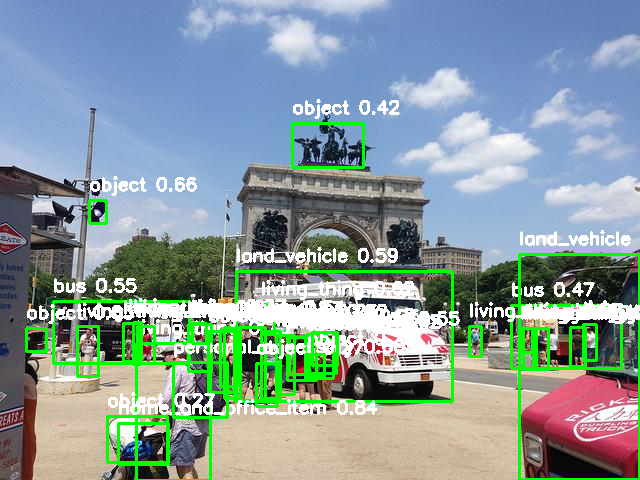

In [21]:
hierarchical_loss.viz_utils.draw_boxes_on_image(image, fboxes.T, 
                    labels=[MSCOCOHierarchicalDetectionTrainer.id_to_name[fpath[-1]] for fpath in fpaths], 
                    scores=[float(torch.prod(fscore)) for fscore in fscores], box_color=(0, 255, 0), text_color=(255, 255, 255))